In [1]:
import cortx_community as cc
import cortx_graphing as cg
from github import Github  # https://pygithub.readthedocs.io/
import github
import pickle
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import requests
from collections import Counter
from IPython.display import Markdown, display, Pretty, Latex, HTML

%matplotlib inline

In [2]:
##################
# Initialization #
##################

def Verbose(String,warning_msgs=None):
    v = False
    if v:
        print(String) 
    if warning_msgs:
        warning_msgs.append(String)

gh = Github(os.environ.get('GH_OATH'))
cc.avoid_rate_limiting(gh,10,False)

repos=[]
repos=cc.get_repos(None,'Seagate','cortx')
rnames = [r.name for r in repos]
Verbose("CORTX Repos: %s" % ", ".join(rnames))

# Set global values for seaborn
sns.set(rc = {'figure.figsize':(15,15)})

# warning messages
warning_msgs = []

# scores to make the overall winners
Total_scores = { key : 0 for key in rnames }

In [31]:
#####################
# helper functions  #
#####################

# we want to make 4 graphs comparing all the repos:
# comparing age of each open issue
# comparing latency of each open issue
# comparing age of each open pull request
# comparing latency of each open pull request
def get_stats_structure():
    stats = {}
    for repo in repos:
        stats[repo.name] = {}
        for Type in ('issues','pullrequests'):
            for metric in ('age','latency'):
                stats[repo.name]['%s_%s' % (Type,metric)] = []
    return(stats)

def get_response_latency_and_age_in_days(issue):
    birth=issue.created_at
    age = (datetime.utcnow() - birth).total_seconds()
    latency = age # in case there are no good comments, just use age
    for comment in issue.get_comments():
        if '[bot]' not in comment.user.login:
            latency = (comment.created_at - birth).total_seconds()
            break
    return(latency/86400.0,age/86400.0)
        
def add_caption(plt,strings):
    offset=-0.1
    offset_shift=-0.06
    for string in strings:
        plt.figtext(.1, offset, string, size=20)
        offset += offset_shift
    
def get_type(issue):
    if issue.pull_request is None:
        Type="issues"
    else:
        Type="pullrequests"
    return Type

def get_gh_metrics(repo,issues,stats):
    Verbose("Getting metrics for %s" % repo)
    for issue in issues[repo]:
        cc.avoid_rate_limiting(gh,10,False)
        (lat,age) = get_response_latency_and_age_in_days(issue)
        Type = get_type(issue)
        stats[repo]['%s_latency' % Type].append(lat)
        stats[repo]['%s_age' % Type].append(age)

def make_bar_graph(config,repos,orient='v'):
    #set seaborn plotting aesthetics
    sns.set(style='white')
    sns.set(font_scale = 2)

    #create grouped bar chart
    try:
        ordering = config['ordering']
    except KeyError:
        ordering = sorted(repos)

    g = sns.barplot(x=config['x'], y=config['y'], hue=config['hue'], data=config['df'], order=ordering, orient=orient) 
    #g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set(xlabel=None) # remove xlabel
    g.set(ylabel=None) # and ylabel
    g.axes.set_title(config['title'])
    #g.tick_params(labelsize=16)

    # remove title from legend
    handles, labels = g.get_legend_handles_labels()
    g.legend(handles=handles[0:], labels=labels[0:])
    
    try:
        plt.legend(loc=config['key_loc'])
    except KeyError:
        pass
    return g

def make_boxplot(metric,title,ylabel):
    fontsize=16
    df = pd.DataFrame(
        columns=[metric,'repo'])
    for repo in repos:
        for value in stats[repo.name][metric]:
            df.loc[len(df.index)] = [value,repo.name]
    ordering = sorted([repo.name for repo in repos])
    bplot=sns.boxplot(y=metric, x='repo', 
                 data=df, 
                 width=0.75,
                 order=ordering,
                 palette="colorblind")
    bplot=sns.stripplot(y=metric, x='repo',
              data=df, 
              order=ordering,
              color='black',
              alpha=0.75)
    
    bplot.axes.set_title(title,fontsize=16)
    bplot.set(xlabel=None)
    bplot.set_ylabel(ylabel,fontsize=fontsize)
    bplot.tick_params(labelsize=16)
    bplot.set_xticklabels(bplot.get_xticklabels(),rotation=90)
    return bplot

def get_codacy(url,data=None):
    codacy_url=url
    oath=os.getenv('CODACY_OATH')
    headers={"api-token":oath, "Accept":"application/json"}
    #print(oath)
    if data:
        headers['Content-Type'] = 'application/json'
        r = requests.post(codacy_url, headers=headers, data=data)
    else:
        r = requests.get(codacy_url, headers=headers)
    #print(r)
    #print(r.url)
    #r.text
    return r


In [4]:
###########################
# codacy helper functions #
###########################

def check_security(repo):
    url=codacy_base + "/%s/issues/search" % repo
    data={}
    data['levels'] = ["Error", "Warning"]
    data["categories"] = ["Security"]
    response = get_codacy(url=url,data=json.dumps(data))
    local_warnings = 0
    errors = 0
    for i in response.json()['data']:
        if i['patternInfo']['level'] == 'Warning':
            local_warnings += 1
        elif i['patternInfo']['level'] == 'Error':
            errors += 1
        else:
            warning = 'Warning: unknown severity level in repo %s' % repo
            Verbose(warning,warning_msgs)
    return(local_warnings,errors)

def get_codacy_stats(repo):
    def set_metric(metric,metrics,Json):
        metrics[metric] = Json['data'][metric]
    url="%s/%s" % (codacy_base, repo)
    response = get_codacy(url=url)
    Json = response.json()
    local_metrics = {}
    #print(Json['data']['coverage'])
    for m in ['grade', 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage']:
        try:
            set_metric(m,local_metrics,Json)
        except KeyError:
            warning = "Warning: No value for %s in repo %s" % (m,r)
            Verbose(warning,warning_msgs)
    coverage=Json['data']['coverage']
    local_metrics['coverage'] = 100 * (1.0 * (coverage['numberTotalFiles']-coverage['filesUncovered'])) / coverage['numberTotalFiles']
    return (local_metrics,Json)

In [5]:
#########################
# scrape github metrics #
#########################

issues={}
for r in repos:
    issues[r.name]=[]
    for i in r.get_issues(state='open'):
        issues[r.name].append(i)
    Verbose("Fetched %d open issues for %s" % (len(issues[r.name]), r.name))

stats = get_stats_structure() # initialize the structure
for repo in repos:
    get_gh_metrics(repo.name,issues,stats)
    
# scrape github to get the branch count for each repo
for r in repos:
    branches = r.get_branches()
    stats[r.name]['branch_count'] = branches.totalCount
    # blech, seems to be no way to get the age of a branch...
    #stats[r.name]['branches_age'] = []
    #for b in branches:
    #    print(b.commit.commit.html_url)
    #    age = ((datetime.utcnow() - b.created_at).total_seconds()) / 86400
    #    stats[r.name]['branches_age'].append(age)
    Verbose("Repo %s has %d branches" % (r.name, stats[r.name]['branch_count']))
    # github shows stale branches (e.g. https://github.com/Seagate/cortx-motr/branches/stale?page=1)
    # their definition is if branch.commit.commit.committer.date is greater than 90 days old
    stats[r.name]['stale_branch_count'] = 0
    for branch in branches:
        cc.avoid_rate_limiting(gh,10,False)
        age = ((datetime.utcnow() - branch.commit.commit.committer.date).total_seconds()) / 86400.0
        if age >= 90:
            Verbose("%s branch %s is %.2f days old; therefore stale" % (r.name,branch.name,age))
            stats[r.name]['stale_branch_count'] += 1

In [6]:
#########################
# scrape codacy metrics #
#########################

# get the list of all codacy repos
codacy_base='https://app.codacy.com/api/v3/analysis/organizations/gh/Seagate/repositories'
response=get_codacy(codacy_base)
#Verbose(response.json())
Json=response.json()
if Json['pagination']['total'] >= Json['pagination']['limit']:
    print("Ugh. Have to deal with pagination.")
else:
    Verbose("Do not need to deal with pagination")
codacy_repos = []
github_repos = [r.name for r in repos]
for item in Json['data']:
    repo=item['repository']
    rname=repo['name']
    vis=repo['visibility']
    if 'cortx' in rname and vis == 'Public':
        if rname not in github_repos:
            Verbose("Skipping %s because not in github repos" % rname) # because it is archived probably
        else:
            codacy_repos.append(rname)
Verbose(", ".join(codacy_repos))

# now get metrics from each of them
codacy_metrics = {}
for r in codacy_repos:
    Verbose("Fetching codacy %s" % r)
    codacy_metrics[r]=get_codacy_stats(r)[0]
#print(metrics)

# now add security counts from codacy
for r in codacy_repos:
    (warnings,errors) = check_security(r)
    codacy_metrics[r]['security_warnings'] = warnings
    codacy_metrics[r]['security_errors'] = errors
    Verbose("repo %s security : %d warnings, %d errors" % (r, warnings, errors))

In [7]:
display(Markdown("<h1><center>%s</center></h1>" % "CORTX Repositories Health Report"))
today=datetime.today().strftime("%B %d, %Y")
display(Markdown("<h3>%s</h3>" % today))

<h1><center>CORTX Repositories Health Report</center></h1>

<h3>April 06, 2022</h3>

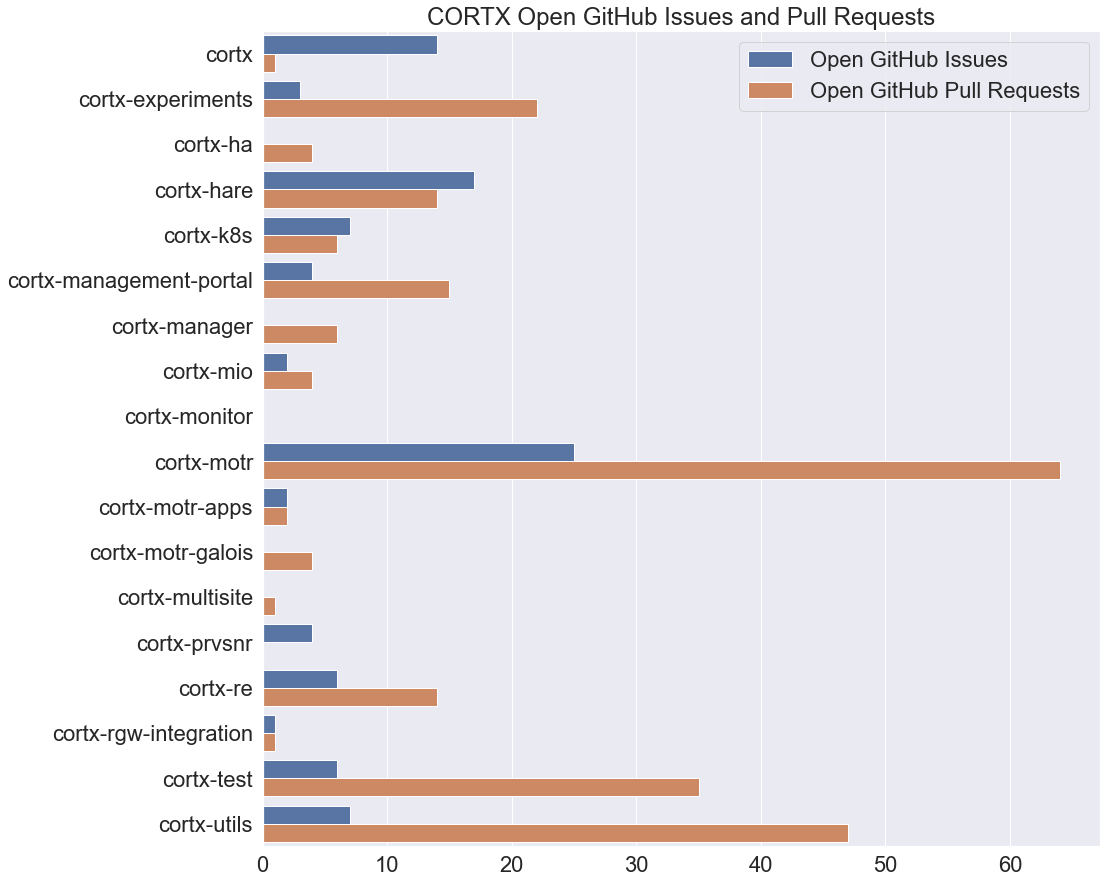

In [32]:
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    num_issues = len(stats[repo]['issues_age'])
    num_prs = len(stats[repo]['pullrequests_age'])
    df.loc[len(df.index)] = [repo,num_issues,'Open GitHub Issues']
    df.loc[len(df.index)] = [repo,num_prs,'Open GitHub Pull Requests']

config={'y' : 'Repo', 'x' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX Open GitHub Issues and Pull Requests"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames,orient='h')
plt.show()

In [10]:
# reverse=True if high score is best
# reverse=False if low score is best
def add_scores(scores,metric,stats,reverse):
    def find_scores(score,Dict):
        List = []
        for k,v in Dict.items():
            if v == score:
                List.append(k)
        return List
    
    tmp_dict = {key: 0 for key in stats.keys()}
    for r in tmp_dict.keys():
        try:
            item = stats[r][metric]
            if isinstance(item, list):
                try:
                    tmp_dict[r] = sum(item) * 1.0 / len(item)
                except ZeroDivisionError:
                    tmp_dict[r] = 0
            else:
                tmp_dict[r] = item
        except KeyError: # for some reason, some repos don't have all metrics
            pass
    my_keys = sorted(tmp_dict, key=tmp_dict.get, reverse=reverse)
    points = [5,3,1]
    top_score    = tmp_dict[my_keys[0]]
    second_score = 0
    third_score  = 0
    for k in my_keys:
        if tmp_dict[k] != top_score:
            second_score = tmp_dict[k]
            break
    for k in my_keys:
        if tmp_dict[k] != top_score and tmp_dict[k] != second_score:
            third_score = tmp_dict[k]
            break
    Verbose("Top scores are %.2f, %.2f, %.2f" % (top_score,second_score,third_score))
    num_winners = 0
    winners = find_scores(top_score,tmp_dict)
    num_winners += len(winners)
    for winner in winners:
        scores[winner] += 5
    if num_winners < 3:
        winners = find_scores(second_score,tmp_dict)
        for winner in winners:
            scores[winner] += 3
        num_winners += len(winners)
    if num_winners < 3:
        winners = find_scores(third_score,tmp_dict)
        for winner in winners:
            scores[winner] += 1
    Verbose("Scores are now %s" % json.dumps(scores)) 

In [11]:
add_scores(Total_scores,'issues_age',stats,False)
add_scores(Total_scores,'pullrequests_age',stats,False)

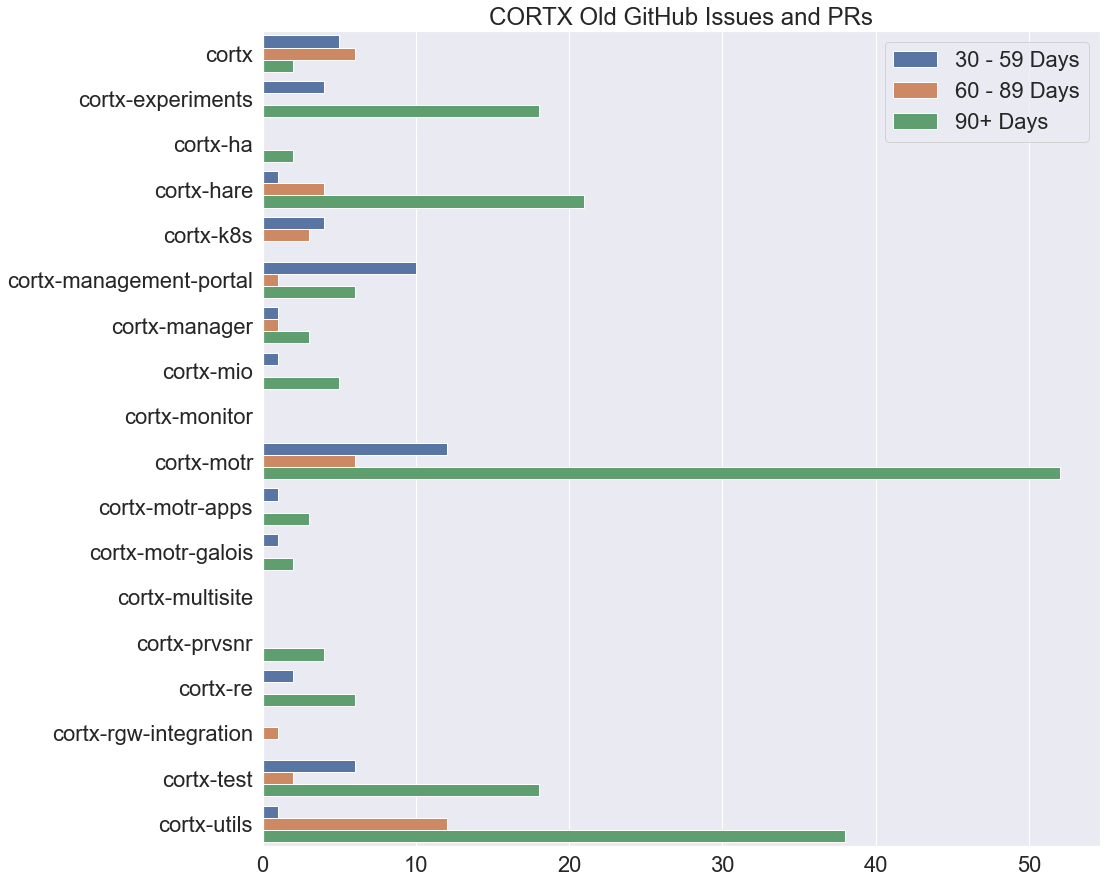

In [12]:
# count and bucketize old issues and prs
for r in repos:
    repo = r.name
    stats[repo]['30-59']=0
    stats[repo]['60-89']=0
    stats[repo]['90+']=0
    for item in stats[repo]['pullrequests_age'] + stats[repo]['issues_age']:
        if item >= 30 and item < 60:
            stats[repo]['30-59'] += 1
        elif item >=60 and item < 89:
            stats[repo]['60-89'] += 1
        elif item >= 90:
            stats[repo]['90+'] += 1

# make a bar graph for it
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    thirty_bucket = stats[repo]['30-59']
    sixty_bucket  = stats[repo]['60-89']
    ninety_bucket = stats[repo]['90+']
    df.loc[len(df.index)] = [repo,thirty_bucket,'30 - 59 Days']
    df.loc[len(df.index)] = [repo,sixty_bucket, '60 - 89 Days']
    df.loc[len(df.index)] = [repo,ninety_bucket,'90+ Days']
        
config={'y' : 'Repo', 'x' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX Old GitHub Issues and PRs"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames,orient='h')
plt.show()

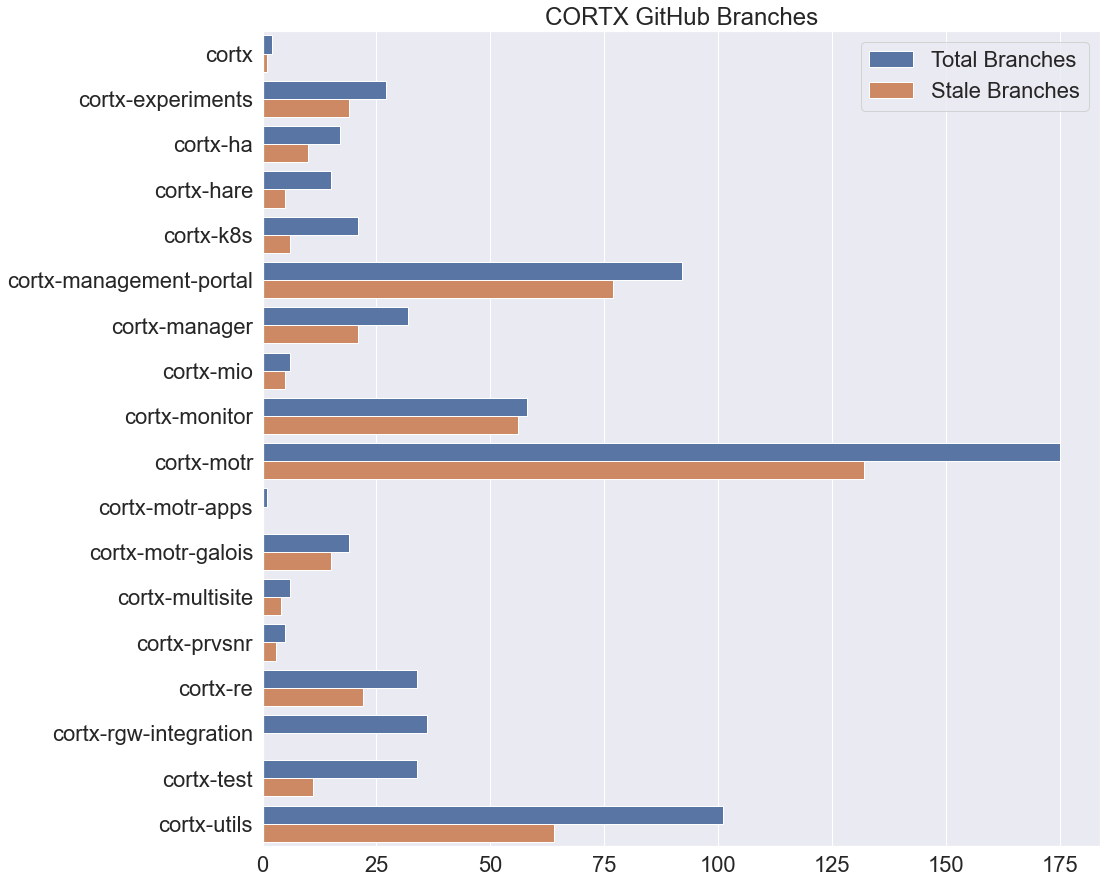

In [13]:
# make a bar graph for branch count
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    num_branches = stats[r.name]['branch_count']
    num_stale = stats[r.name]['stale_branch_count']
    df.loc[len(df.index)] = [repo,num_branches,'Total Branches']
    df.loc[len(df.index)] = [repo,num_stale,   'Stale Branches']

config={'y' : 'Repo', 'x' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX GitHub Branches"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames,orient='h')
plt.show()

add_scores(Total_scores,'branch_count',stats,False)
add_scores(Total_scores,'stale_branch_count',stats,False)

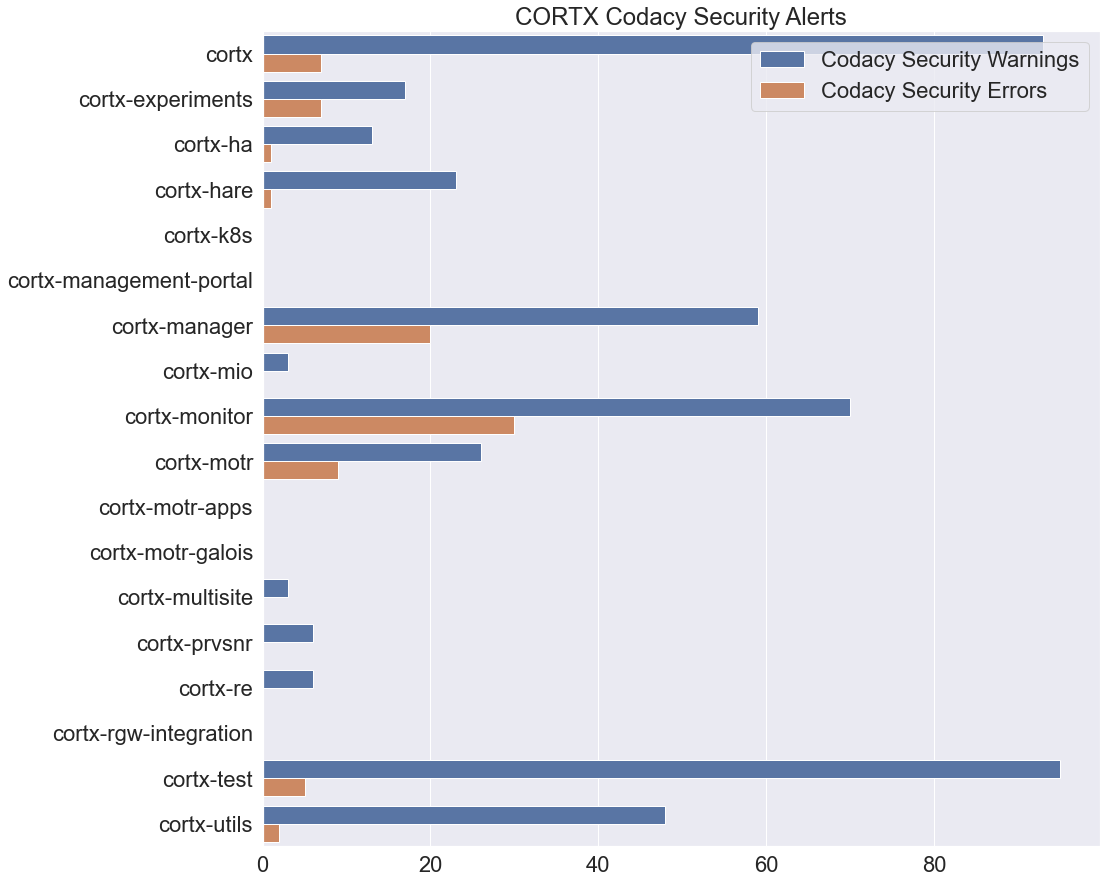

In [14]:
# make a bar chart for security
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    repo = r
    sec_warn = codacy_metrics[r]['security_warnings']
    sec_err  = codacy_metrics[r]['security_errors']
    df.loc[len(df.index)] = [repo,sec_warn,'Codacy Security Warnings']
    df.loc[len(df.index)] = [repo,sec_err, 'Codacy Security Errors']

config={'y' : 'Repo', 'x' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Codacy Security Alerts', 'df' : df}    
graph = make_bar_graph(config,codacy_repos,orient='h')
plt.show()

add_scores(Total_scores,'security_warnings',codacy_metrics,False)
add_scores(Total_scores,'security_errors',codacy_metrics,False)

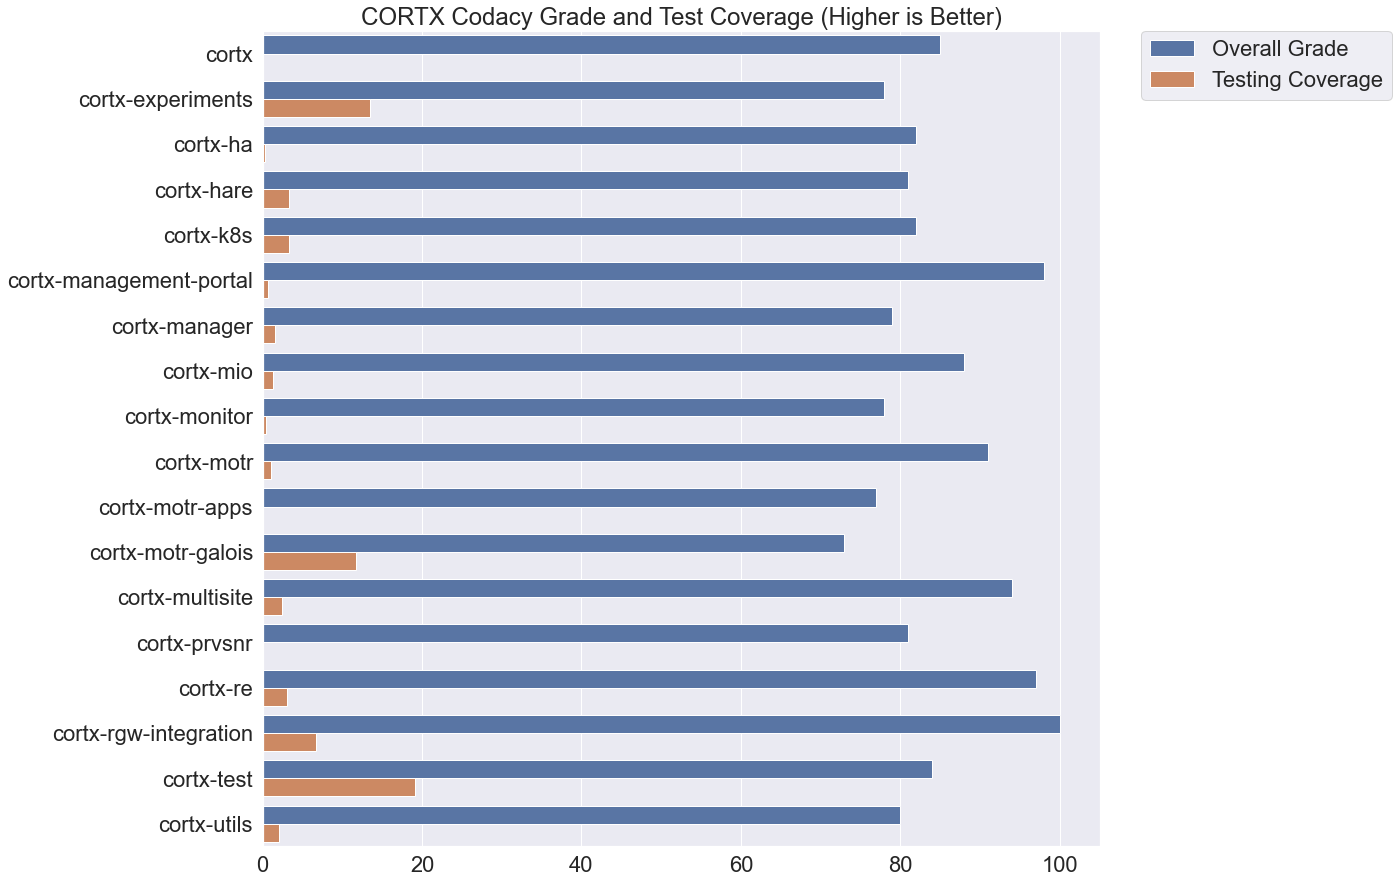

In [15]:
# make a bar chart for grade and coverage
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    grade = codacy_metrics[r]['grade']
    cover = codacy_metrics[r]['coverage']
    df.loc[len(df.index)] = [r,grade, 'Overall Grade']
    df.loc[len(df.index)] = [r,cover, 'Testing Coverage']

config={'y' : 'Repo', 'x' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Codacy Grade and Test Coverage (Higher is Better)', 
        'df' : df}    
graph = make_bar_graph(config,codacy_repos,orient='h')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

add_scores(Total_scores,'grade',codacy_metrics,True)
add_scores(Total_scores,'coverage',codacy_metrics,True)

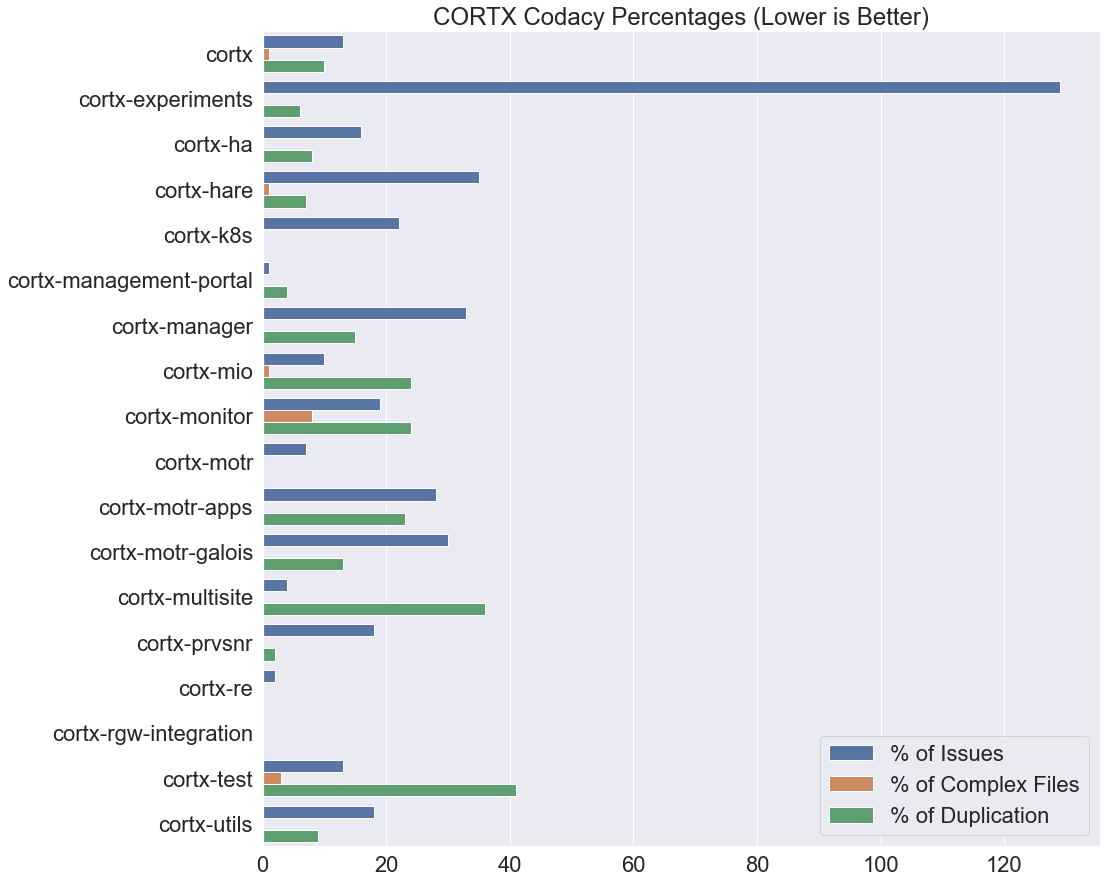

In [16]:
# make a bar chart for 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage'
graph_metrics = { 'issuesPercentage' : '% of Issues', 
                  'complexFilesPercentage' : '% of Complex Files',
                  'duplicationPercentage' : '% of Duplication'
                }
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    for k,label in graph_metrics.items():
        try:
            value = codacy_metrics[r][k]
            df.loc[len(df.index)] = [r, value, label]
        except KeyError:
            warning = "Warning: No value for %s in repo %s" % (k, r)
            Verbose(warning,warning_msgs)

config={'y' : 'Repo', 'x' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Codacy Percentages (Lower is Better)', 
        'df' : df}    
graph = make_bar_graph(config,codacy_repos,orient='h')
plt.show()

add_scores(Total_scores,'issuesPercentage',codacy_metrics,False)
add_scores(Total_scores,'complexFilesPercentage',codacy_metrics,False)
add_scores(Total_scores,'duplicationPercentage',codacy_metrics,False)

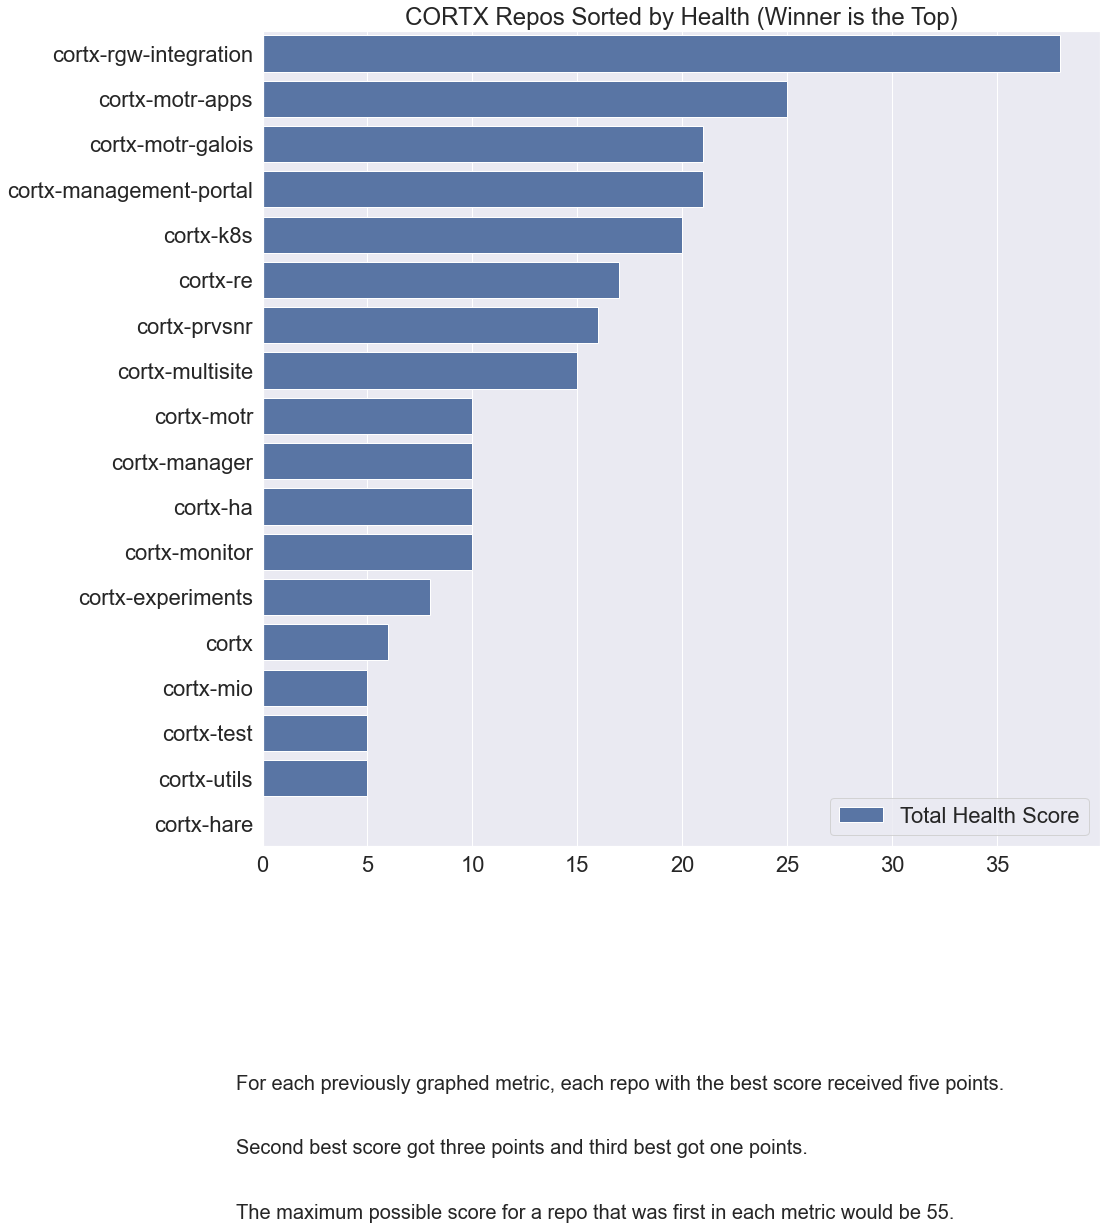

In [36]:
##################
# Overall Scores #
##################
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    overall_score = Total_scores[r.name]
    df.loc[len(df.index)] = [repo,overall_score,'Total Health Score']

ordering = reversed(sorted(Total_scores, key=Total_scores.get))
config={'y' : 'Repo', 'x' : 'Quantity', 'df' : df, 'hue' : 'Type', 
        'title' : "CORTX Repos Sorted by Health (Winner is the Top)",
       'ordering' : ordering, 'key_loc' : 'lower right'}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames,orient='h')
add_caption(plt,
            ["For each previously graphed metric, each repo with the best score received five points.",
             "Second best score got three points and third best got one points.",
             "The maximum possible score for a repo that was first in each metric would be 55."
            ])
plt.show()

In [18]:
display(Markdown("<h1><center>%s</center></h1>" % "More Detailed Breakdown of Issues and Pull Requests"))

<h1><center>More Detailed Breakdown of Issues and Pull Requests</center></h1>

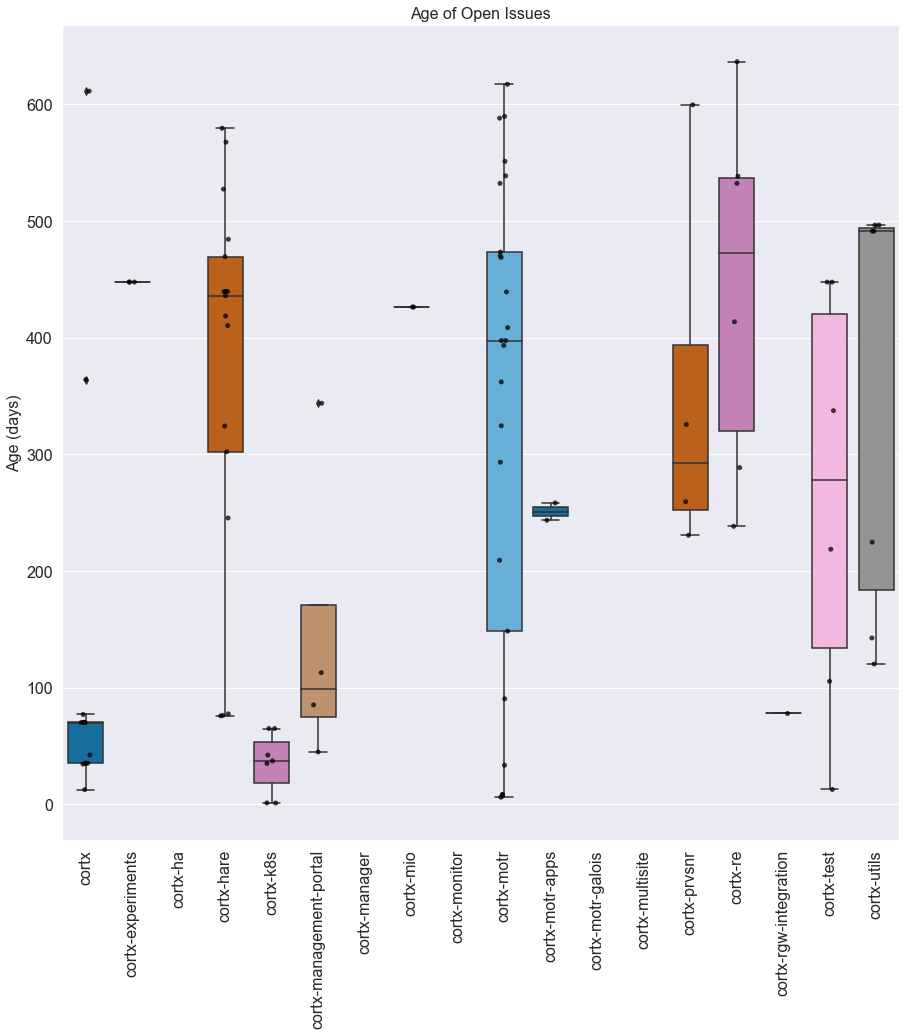

In [19]:
make_boxplot('issues_age','Age of Open Issues', 'Age (days)')
plt.show()

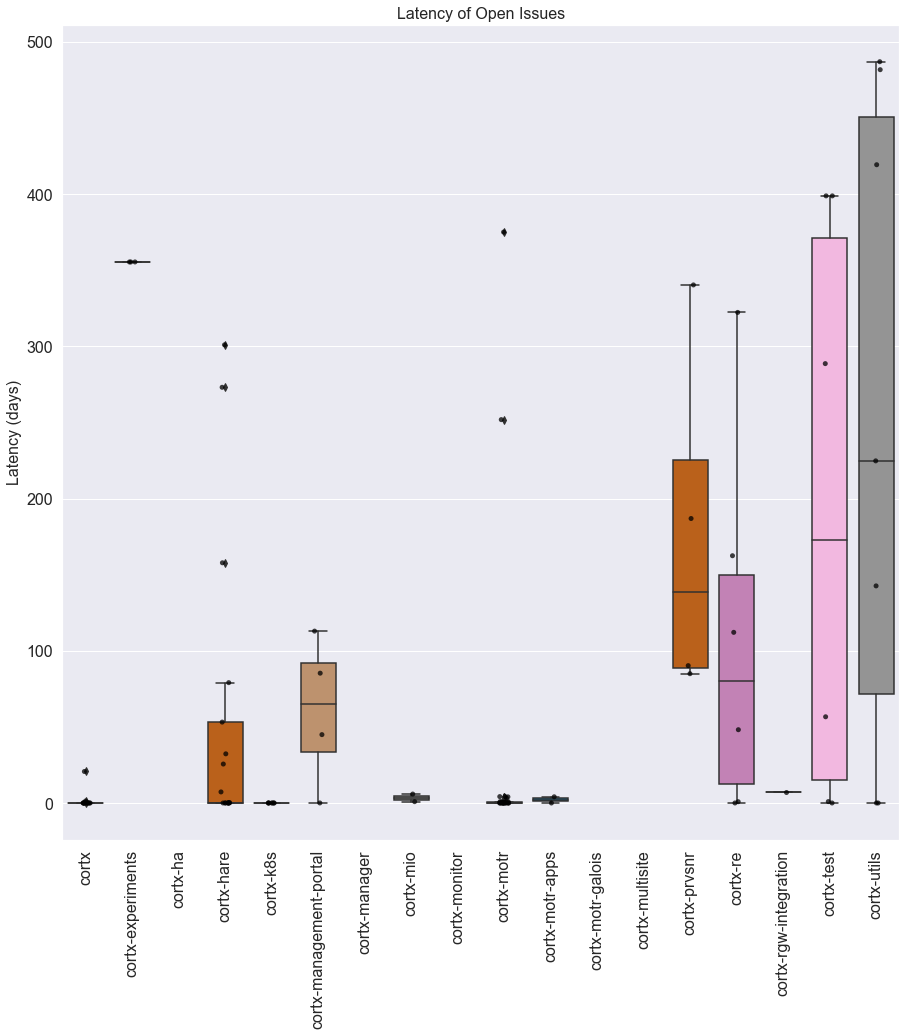

In [20]:
make_boxplot('issues_latency','Latency of Open Issues', 'Latency (days)')
plt.show()

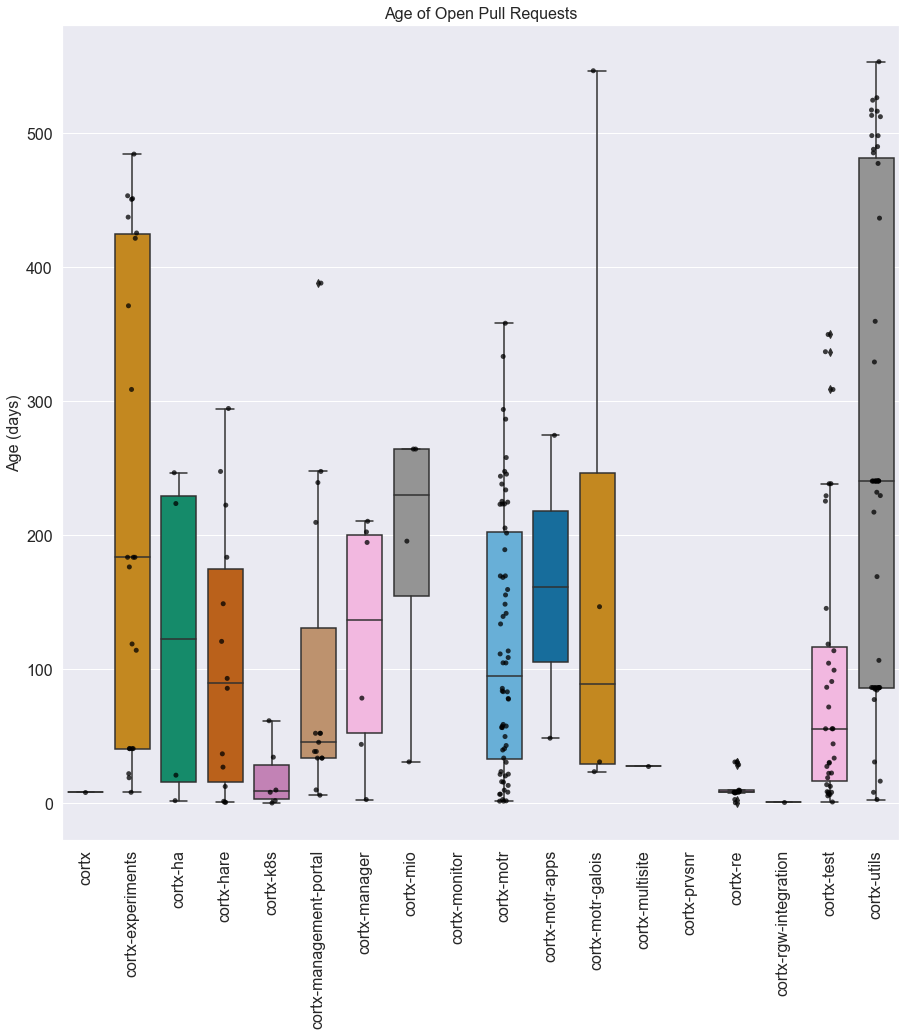

In [21]:
make_boxplot('pullrequests_age','Age of Open Pull Requests', 'Age (days)')
plt.show()

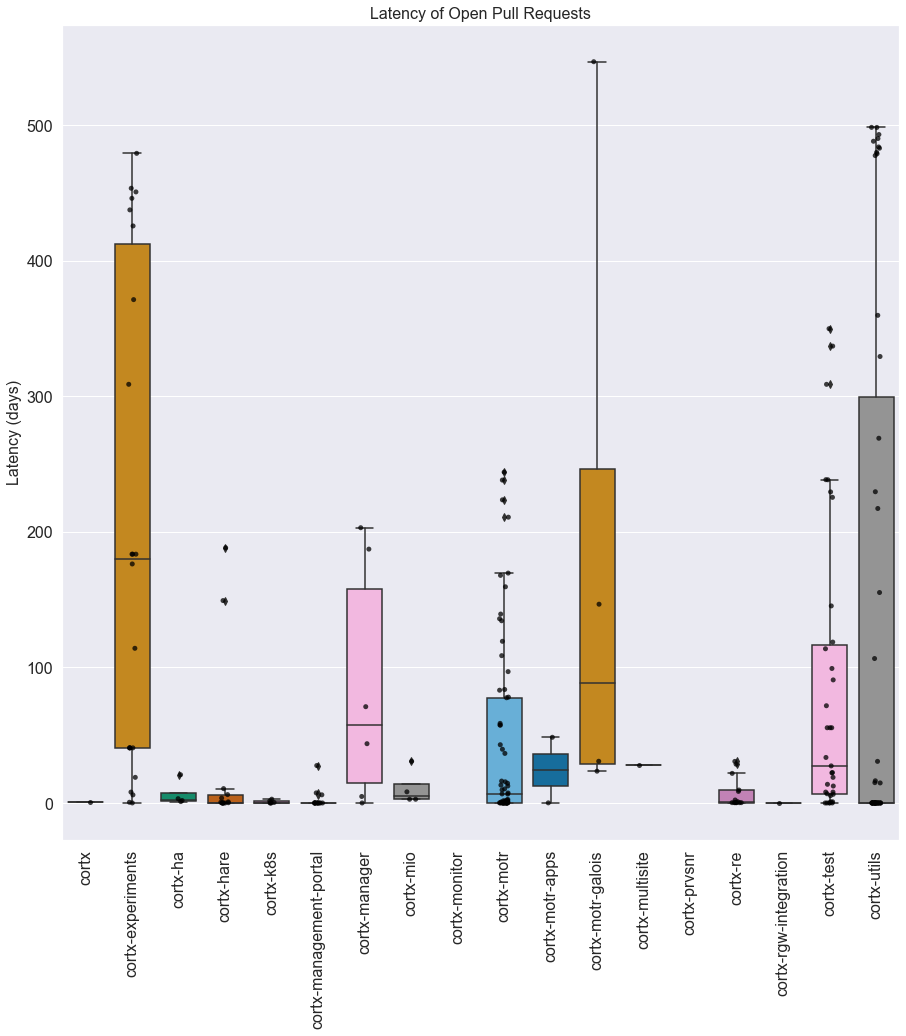

In [22]:
make_boxplot('pullrequests_latency','Latency of Open Pull Requests', 'Latency (days)')
plt.show()

In [23]:
# save to the pickle file
pfile = 'pickles/health.pickle'

# first load the old pickle if any
try:
    f = open(pfile, 'rb')
    pickle_struct = pickle.load(f)
    f.close()
    Verbose("augmenting existing pickle")
except FileNotFoundError:
    pickle_struct = {}
    Verbose("creating new pickle")

now=datetime.now().strftime("%m/%d/%Y")
pickle_struct[now] = {}
pickle_struct[now]['github']=stats
pickle_struct[now]['codacy']=codacy_metrics

# save the pickle file
with open(pfile, 'wb') as f:
    pickle.dump(pickle_struct, f)

UnpicklingError: invalid load key, 'v'.